In [159]:
%config IPCompleter.greedy=True 
%env OMP_NUM_THREADS = 4
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import random
from sklearn.model_selection import RandomizedSearchCV
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

env: OMP_NUM_THREADS=4


In [160]:
data = pd.read_csv("C:/Users/krist/Desktop/Queens/MMA 869/OJ.csv")

In [3]:
data.head()

WeekofPurchase  StoreID  PriceCH  PriceMM  DiscCH  DiscMM  SpecialCH  \
0             237        1     1.75     1.99    0.00     0.0          0   
1             239        1     1.75     1.99    0.00     0.3          0   
2             245        1     1.86     2.09    0.17     0.0          0   
3             227        1     1.69     1.69    0.00     0.0          0   
4             228        7     1.69     1.69    0.00     0.0          0   

   SpecialMM   LoyalCH Purchase  
0          0  0.500000       CH  
1          1  0.600000       CH  
2          0  0.680000       CH  
3          0  0.400000       MM  
4          0  0.956535       CH

In [161]:
data['Purchase'] = data['Purchase'].map({'CH': 1, 'MM': 0}) #converting CH/MM to factor 1/0

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WeekofPurchase  1070 non-null   int64  
 1   StoreID         1070 non-null   int64  
 2   PriceCH         1070 non-null   float64
 3   PriceMM         1070 non-null   float64
 4   DiscCH          1070 non-null   float64
 5   DiscMM          1070 non-null   float64
 6   SpecialCH       1070 non-null   int64  
 7   SpecialMM       1070 non-null   int64  
 8   LoyalCH         1070 non-null   float64
 9   Purchase        1070 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 83.7 KB


In [6]:
data["StoreID"]=data["StoreID"].astype('category')

In [7]:
data.shape

(1070, 10)

In [162]:
#checking for missing values
data.isna().sum()

WeekofPurchase    0
StoreID           0
PriceCH           0
PriceMM           0
DiscCH            0
DiscMM            0
SpecialCH         0
SpecialMM         0
LoyalCH           0
Purchase          0
dtype: int64

In [9]:
#EDA of features
prof = ProfileReport(data, minimal=False) 
prof.to_notebook_iframe()

FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C39BC15B0>,
                   color=None, feature_index=None, feature_names=None,
                   labels=None, method='mutual_info-classification', sort=True)

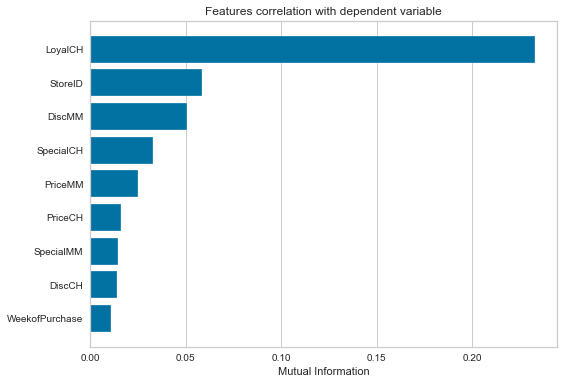

In [163]:
#looking at feature correlation with target feature
from yellowbrick.target import FeatureCorrelation

visualizer = FeatureCorrelation(method='mutual_info-classification', sort=True)
visualizer.fit(data.iloc[:,:-1], data["Purchase"], random_state=0)
visualizer.poof()

In [165]:
data=pd.get_dummies(data, columns = data.select_dtypes(exclude='number').columns, drop_first = True)

In [166]:
data.head()

WeekofPurchase  StoreID  PriceCH  PriceMM  DiscCH  DiscMM  SpecialCH  \
0             237        1     1.75     1.99    0.00     0.0          0   
1             239        1     1.75     1.99    0.00     0.3          0   
2             245        1     1.86     2.09    0.17     0.0          0   
3             227        1     1.69     1.69    0.00     0.0          0   
4             228        7     1.69     1.69    0.00     0.0          0   

   SpecialMM   LoyalCH  Purchase  
0          0  0.500000         1  
1          1  0.600000         1  
2          0  0.680000         1  
3          0  0.400000         0  
4          0  0.956535         1

In [167]:
from sklearn.model_selection import train_test_split

X = data.drop(['Purchase'], axis=1)
y = data[['Purchase']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [168]:
from sklearn import preprocessing
PriceCH = data[['PriceCH']].copy()

scaler = preprocessing.StandardScaler().fit(PriceCH[['PriceCH']])
PriceCH['PriceCH_Scaled'] = scaler.transform(PriceCH[['PriceCH']])   

scaler = preprocessing.MinMaxScaler().fit(PriceCH[['PriceCH']])
PriceCH['PriceCH_MinMax'] = scaler.transform(PriceCH[['PriceCH']])   

scaler = preprocessing.PowerTransformer(method='yeo-johnson').fit(PriceCH[['PriceCH']])
PriceCH['PriceCH_YeoJohnson'] = scaler.transform(PriceCH[['PriceCH']])  

scaler = preprocessing.QuantileTransformer(random_state=0).fit(PriceCH[['PriceCH']])
PriceCH['PriceCH_Uniform'] = scaler.transform(PriceCH[['PriceCH']])  

scaler = preprocessing.FunctionTransformer(np.log1p, validate=True).fit(PriceCH[['PriceCH']])
PriceCH['PriceCH_Log'] = scaler.transform(PriceCH[['PriceCH']])  

<Figure size 1152x720 with 0 Axes>

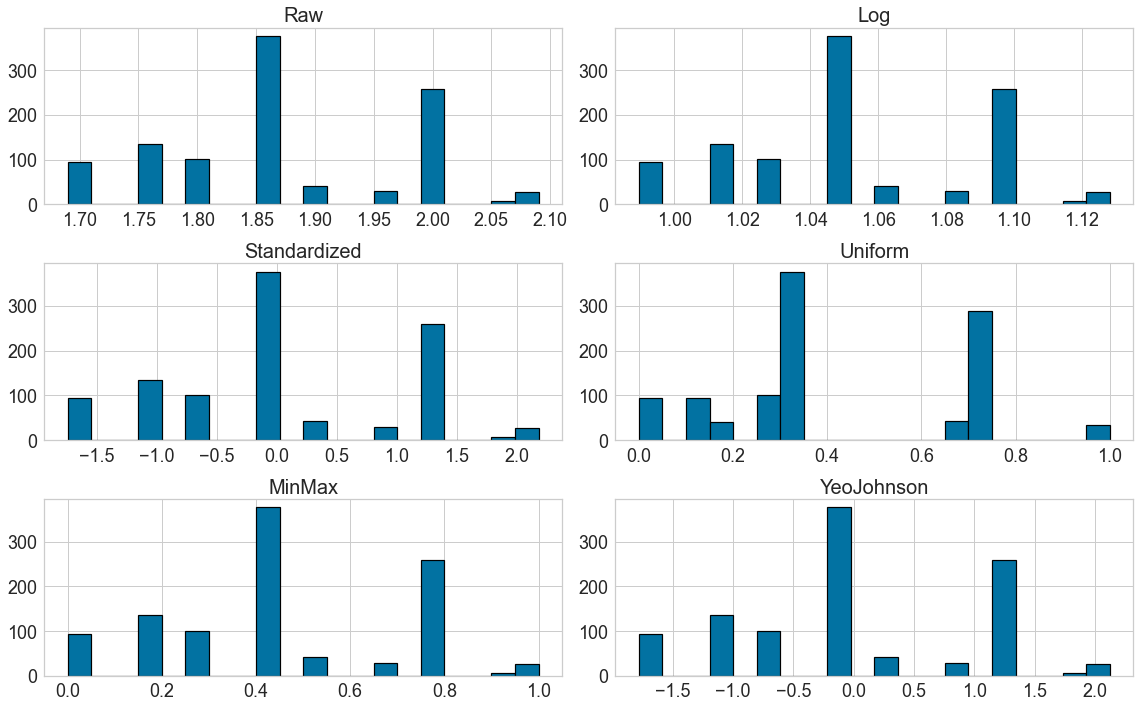

In [169]:
#checking which transformation could be the best

def plot_hist(ax, feature, title):
    ax.hist(feature, bins=20, edgecolor='black', linewidth=1.2);
    ax.set_title(title, fontsize=20);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);

plt.figure(figsize=(16, 10));
plt.grid(True);
plot_hist(plt.subplot(3, 2, 1), PriceCH['PriceCH'], 'Raw')
plot_hist(plt.subplot(3, 2, 2), PriceCH['PriceCH_Log'], 'Log')
plot_hist(plt.subplot(3, 2, 3), PriceCH['PriceCH_Scaled'], 'Standardized')
plot_hist(plt.subplot(3, 2, 4), PriceCH['PriceCH_Uniform'], 'Uniform')
plot_hist(plt.subplot(3, 2, 5), PriceCH['PriceCH_MinMax'], 'MinMax')
plot_hist(plt.subplot(3, 2, 6), PriceCH['PriceCH_YeoJohnson'], 'YeoJohnson')

In [170]:
scaler = preprocessing.StandardScaler().fit(X[['PriceCH','PriceMM','DiscCH','DiscMM','LoyalCH']])
X[['PriceCH','PriceMM','DiscCH','DiscMM','LoyalCH']] = scaler.transform(X[['PriceCH','PriceMM','DiscCH','DiscMM','LoyalCH']])
X.head()

WeekofPurchase  StoreID   PriceCH   PriceMM    DiscCH    DiscMM  SpecialCH  \
0             237        1 -1.152062 -0.710313 -0.441664 -0.577188          0   
1             239        1 -1.152062 -0.710313 -0.441664  0.826428          0   
2             245        1 -0.072806  0.034162  1.006140 -0.577188          0   
3             227        1 -1.740747 -2.943741 -0.441664 -0.577188          0   
4             228        7 -1.740747 -2.943741 -0.441664 -0.577188          0   

   SpecialMM   LoyalCH  
0          0 -0.213788  
1          1  0.111205  
2          0  0.371200  
3          0 -0.538781  
4          0  1.269920

Cross-validation to check performance on 10 folds

In [171]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
print(cross_val_score(forest_clf,X_train,y_train,cv=10))
print(cross_val_score(forest_clf,X_train,y_train,cv=10).mean())

[0.73255814 0.81395349 0.81395349 0.80232558 0.74418605 0.87209302
 0.72941176 0.84705882 0.82352941 0.8       ]
0.797906976744186


In [172]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
print(cross_val_score(gnb,X_train,y_train,cv=10))
print(cross_val_score(gnb,X_train,y_train,cv=10).mean())

[0.75581395 0.75581395 0.8255814  0.72093023 0.8255814  0.86046512
 0.71764706 0.78823529 0.77647059 0.82352941]
0.7850068399452803


In [173]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
print(cross_val_score(knn_clf,X_train,y_train,cv=10))
print(cross_val_score(knn_clf,X_train,y_train,cv=10).mean())

[0.75581395 0.73255814 0.74418605 0.72093023 0.73255814 0.77906977
 0.61176471 0.77647059 0.76470588 0.76470588]
0.7382763337893297


In [174]:
from sklearn.svm import SVC

svm_clf = SVC() 
print(cross_val_score(svm_clf,X_train,y_train,cv=10))
print(cross_val_score(svm_clf,X_train,y_train,cv=10).mean())

[0.61627907 0.61627907 0.61627907 0.60465116 0.60465116 0.60465116
 0.61176471 0.61176471 0.61176471 0.61176471]
0.610984952120383


In [175]:
from sklearn.linear_model import LogisticRegression
log_clf=LogisticRegression(random_state=42) 
print(cross_val_score(log_clf,X_train,y_train,cv=10))
print(cross_val_score(log_clf,X_train,y_train,cv=10).mean())

[0.77906977 0.80232558 0.8372093  0.84883721 0.79069767 0.84883721
 0.77647059 0.87058824 0.88235294 0.82352941]
0.8259917920656635


In [176]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)
print(cross_val_score(clf,X_train,y_train,cv=10,scoring="precision"))
print(cross_val_score(clf,X_train,y_train,cv=10).mean())

[0.85714286 0.84210526 0.87804878 0.87755102 0.89361702 0.83333333
 0.79545455 0.85454545 0.84       0.87755102]
0.799015047879617


In [177]:
import xgboost
xgb_clf=xgboost.XGBClassifier(random_state=42)
print(cross_val_score(xgb_clf,X_train,y_train,cv=10))
print(cross_val_score(xgb_clf,X_train,y_train,cv=10).mean())

[0.70930233 0.8255814  0.81395349 0.75581395 0.8255814  0.84883721
 0.74117647 0.81176471 0.8        0.81176471]
0.7943775649794802


In initial cross validation LogisticRegression,RandomForest,Naive Bayes,Decision Tree and XGBoost performed the best 

# Running all models before hyper-parameter tuning to see how they perform

# XGBoost Classifier

In [178]:
import xgboost
xgb_clf=xgboost.XGBClassifier(random_state=42)
xgb_clf.fit(X_train,y_train)
y_pred_xgb=xgb_clf.predict_proba(X_test)[:,1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'XGBoost ROC Curve')

0.853525641025641

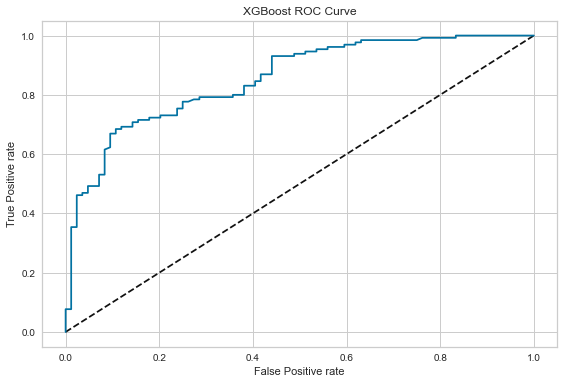

In [179]:
#ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_pred_xgb)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="XGBoost")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("XGBoost ROC Curve")

roc_auc_score(y_test, y_pred_xgb)

In [180]:
from sklearn.metrics import precision_score,recall_score
y_xgb=xgb_clf.predict(X_test)

print(precision_score(y_test,y_xgb))

print(recall_score(y_test,y_xgb))

0.7803030303030303
0.7923076923076923


In [181]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada = AdaBoostClassifier(
    base_estimator=RandomForestClassifier(),n_estimators=500, random_state=42)
clf_ada.fit(X_train, y_train)

y_probas_ada=clf_ada.predict_proba(X_test)[:,1]

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                       

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'ADA ROC Curve')

0.8144688644688645

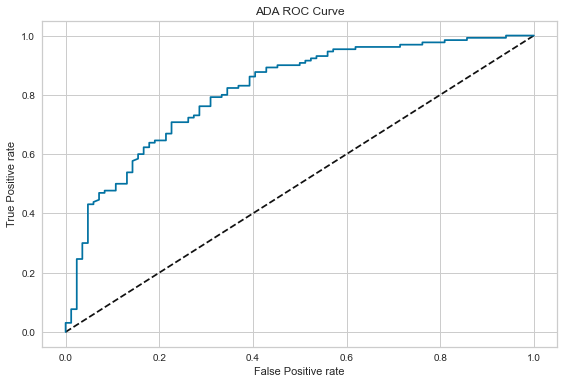

In [182]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_probas_ada)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="ADA")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ADA ROC Curve")

roc_auc_score(y_test, y_probas_ada)

In [183]:
y_ada=clf_ada.predict(X_test)

print(precision_score(y_test,y_ada))

print(recall_score(y_test,y_ada))
print(confusion_matrix(y_test,y_ada))

0.792
0.7615384615384615
[[58 26]
 [31 99]]


# Logistic Regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'Logistic Regression ROC Curve')

0.8940476190476191

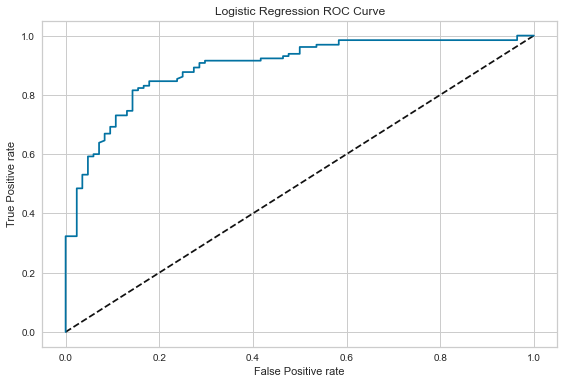

In [184]:
log_clf.fit(X_train,y_train)
y_probas_logistic=log_clf.predict_proba(X_test)[:,1]

#ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_probas_logistic)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="Logistic Regression")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("Logistic Regression ROC Curve")

roc_auc_score(y_test, y_probas_logistic)

For confusion matrix, recall and precision we have to predict probabilities

In [185]:
#Ideally, we want a model with low FP since we don't want the model to make a mistake predicting someone with buy certain juice, while he will not
y_logistic=log_clf.predict(X_test)
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_logistic)   #TN FP
                                           #FN TP

array([[ 58,  26],
       [ 11, 119]], dtype=int64)

In [186]:
from sklearn.metrics import precision_score,recall_score

print(precision_score(y_test,y_logistic))

print(recall_score(y_test,y_logistic))

0.8206896551724138
0.9153846153846154


In [187]:
from sklearn.metrics import f1_score
f1_score(y_test,y_logistic)

0.8654545454545454

In [188]:
from sklearn.metrics import classification_report

class_names = [str(x) for x in log_clf.classes_]
print(classification_report(y_test, y_logistic, target_names=class_names))

              precision    recall  f1-score   support

           0       0.84      0.69      0.76        84
           1       0.82      0.92      0.87       130

    accuracy                           0.83       214
   macro avg       0.83      0.80      0.81       214
weighted avg       0.83      0.83      0.82       214



In [189]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y_test,y_logistic)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_logistic)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_logistic)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_logistic)))

Accuracy = 0.83
Kappa = 0.63
F1 Score = 0.87
Log Loss = 5.97


# Hyper parameter search and tuning for Logistic Regression

In [190]:
from sklearn.model_selection import GridSearchCV

c_space=np.logspace(-5,8,15)
param_grid={"C":c_space,
           "max_iter":[100,200,300,400],
           "penalty":["l1","l2","elasticnet","none"],
           "solver":["newton-cg","lbfgs","liblinear","sag","saga"]}

log_clf_tuned=LogisticRegression(random_state=42)

log_clf_tuned=GridSearchCV(log_clf_tuned,param_grid,cv=10)

log_clf_tuned.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48...
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'max_iter': [100, 200, 300, 400],
                         'penalty'

In [191]:
log_clf_tuned.best_params_

{'C': 2275.845926074791, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}

In [192]:
y_probas_logistic_tuned=log_clf_tuned.predict_proba(X_test)[:,1] #performance slightly decreased with tuning

roc_auc_score(y_test, y_probas_logistic_tuned)

0.8882783882783883

In [193]:
#we have less FP but at a price of increase in FN
y_logistic_tuned=log_clf_tuned.predict(X_test)

confusion_matrix(y_test,y_logistic_tuned)

array([[ 58,  26],
       [ 13, 117]], dtype=int64)

In [194]:
from sklearn.metrics import precision_score,recall_score

print(precision_score(y_test,y_logistic_tuned))

print(recall_score(y_test,y_logistic_tuned))

0.8181818181818182
0.9


# Random Forest

In [195]:
#Fitting Random forest with no hyper parameters tuning
forest_clf.fit(X_train,y_train)
y_pred_forest=forest_clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_forest)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

0.8368131868131868

In [196]:
forest_clf_tuned=RandomForestClassifier(random_state=42)

parameters={"min_samples_leaf":[1,3,5],
            "max_depth":[1,2,5,10,15,20],
             "max_features":[1,5,15,20,17],
            "n_estimators":[50,100,200,300],
             "criterion":["gini","entropy"]}

cv=GridSearchCV(forest_clf_tuned,param_grid=parameters,cv=10)

cv.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

In [197]:
cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'RandomForest ROC Curve')

0.8846153846153847

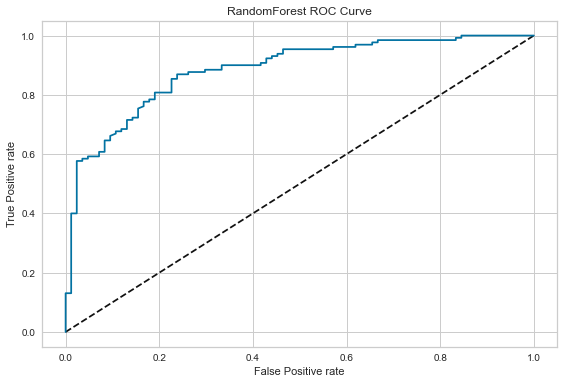

In [198]:
y_probas_forest_tuned=cv.predict_proba(X_test)[:,1]

#ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_probas_forest_tuned)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="Random Forest")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("RandomForest ROC Curve")

roc_auc_score(y_test, y_probas_forest_tuned) #performance improved after tuning

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C6A5B9340>,
                cv=10, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                pre_dispatch='all', scoring='roc_auc')

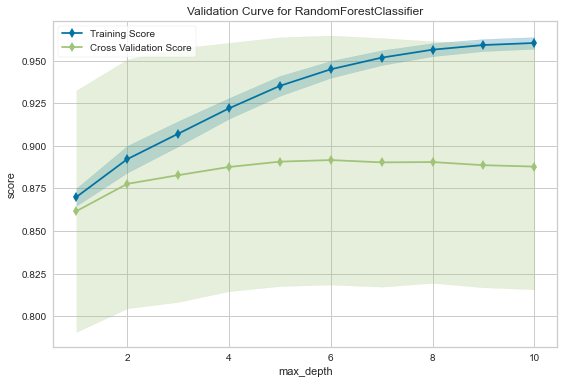

In [199]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=5,n_estimators=300,
                       random_state=42), param_name="max_depth", param_range=np.arange(1, 11), cv=10, scoring="roc_auc")
viz.fit(X, y)
viz.poof()

Trying ADA on tuned random forest to see if performace will improve

In [200]:
clf_ada_tuned = AdaBoostClassifier(
    base_estimator=RandomForestClassifier(max_depth=10, max_features=5, min_samples_leaf=5,n_estimators=300,random_state=42))
clf_ada_tuned.fit(X_train, y_train)

y_probas_ada=clf_ada_tuned.predict_proba(X_test)[:,1]

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=5,
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=2,
                                              

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'Adaboost Tree ROC Curve')

0.8433150183150183

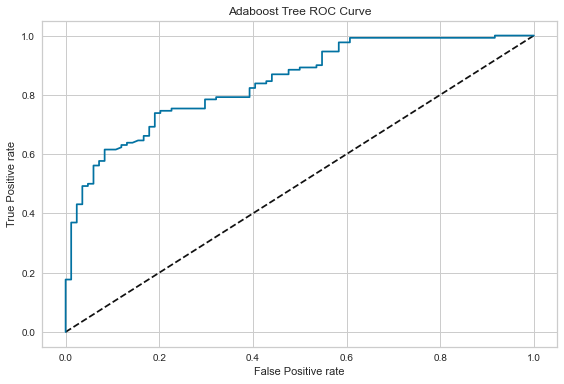

In [201]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_probas_ada)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="Adaboost")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("Adaboost Tree ROC Curve")

roc_auc_score(y_test, y_probas_ada) #auc_score increased

# Decision Tree

In [202]:
clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)
clf.fit(X_train, y_train)

y_pred_dt = clf.predict_proba(X_test)[:,1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'Decision Tree ROC Curve')

0.8547161172161173

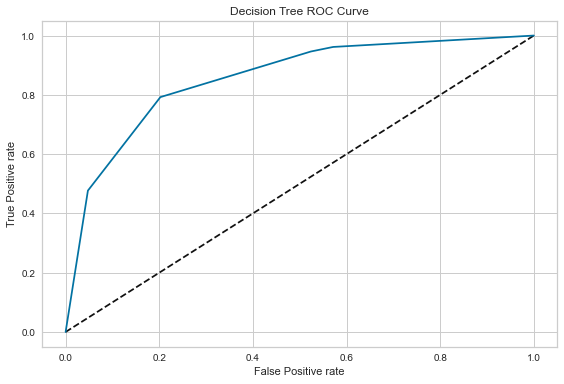

In [203]:
#ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_pred_dt)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="Decision Tree")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("Decision Tree ROC Curve")

roc_auc_score(y_test, y_pred_dt )

In [204]:
y_dt = clf.predict(X_test)
confusion_matrix(y_test, y_dt)

array([[ 67,  17],
       [ 27, 103]], dtype=int64)

In [205]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        84
           1       0.86      0.79      0.82       130

    accuracy                           0.79       214
   macro avg       0.79      0.79      0.79       214
weighted avg       0.80      0.79      0.80       214



In [206]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_dt)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_dt)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_dt)))

Accuracy = 0.79
Kappa = 0.58
F1 Score = 0.82
Log Loss = 7.10


In [207]:
clf_tuned = DecisionTreeClassifier(splitter='best', presort=True, class_weight=None, random_state=42)

parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2, 4, 6, 8, 10], 'min_samples_split':[1,2,5,10, 50], 'min_samples_leaf':[1, 5, 10],
             'max_features':[None, 'auto'], 'max_leaf_nodes':[None, 5, 10,20,50], 'min_impurity_decrease':[0, 0.1, 0.2]}

clf_tuned = GridSearchCV(clf_tuned, parameters, cv=10, return_train_score=True,scoring='roc_auc')

clf_tuned.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=True, random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 4, 6, 8, 10],
                  

In [208]:
clf_tuned.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [209]:
y_dt_tuned = clf_tuned.predict_proba(X_test)[:,1]

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'Decision Tree ROC Curve')

0.858562271062271

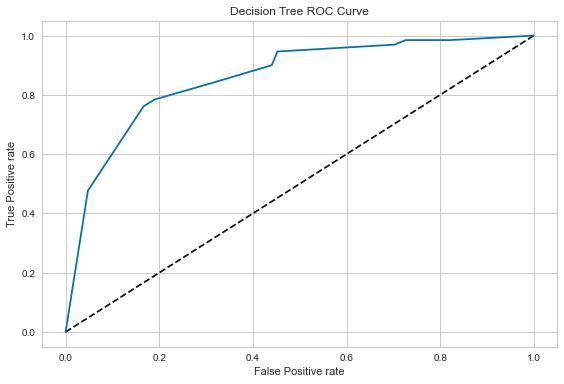

In [210]:
fpr,tpr,thresholds=roc_curve(y_test,y_dt_tuned)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="Decision Tree")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("Decision Tree ROC Curve")

roc_auc_score(y_test, y_dt_tuned) #auc score almost didn't improve

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C6A7BF7F0>,
                cv=5, groups=None, logx=False, model=None, n_jobs=1,
                param_name='max_depth',
                param_range=array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                pre_dispatch='all', scoring='roc_auc')

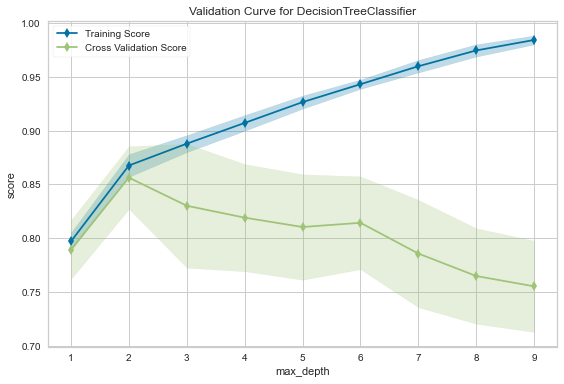

In [211]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(DecisionTreeClassifier(splitter='best', presort=True, class_weight=None, random_state=42), param_name="max_depth", param_range=np.arange(1, 10), cv=5, scoring="roc_auc")
viz.fit(X, y)
viz.poof()

# KNN

In [212]:
knn_clf = KNeighborsClassifier(n_neighbors=9)
knn_clf.fit(X_train, y_train)

y_pred_knn = knn_clf.predict_proba(X_test)[:,1]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

Text(0.5, 0, 'False Positive rate')

Text(0, 0.5, 'True Positive rate')

Text(0.5, 1.0, 'KNN ROC Curve')

0.7714285714285715

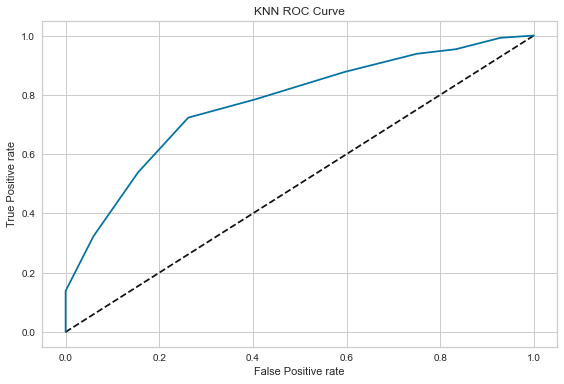

In [214]:
#ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,y_pred_knn)

plt.plot([0,1],[0,1], "k--")
plt.plot(fpr,tpr,label="KNN")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("KNN ROC Curve")

roc_auc_score(y_test, y_pred_knn)

In [216]:
y_knn = knn_clf.predict(X_test)
print(confusion_matrix(y_test, y_knn))
print(classification_report(y_test, y_knn, target_names=class_names)) #high FP rate

[[ 50  34]
 [ 28 102]]
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        84
           1       0.75      0.78      0.77       130

    accuracy                           0.71       214
   macro avg       0.70      0.69      0.69       214
weighted avg       0.71      0.71      0.71       214



In [217]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_knn)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_knn)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_knn)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_knn)))

Accuracy = 0.71
Kappa = 0.38
F1 Score = 0.77
Log Loss = 10.01


# Searching for the best number of k
k=9 has the highest auc score but it is much lower than was RandomForest or LR were able to achieve

In [218]:
k=1
k_range=range(1,13)

for k in k_range:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train, y_train)
    y_pred_knn = knn_clf.predict(X_test)
    y_pred_prob_knn = knn_clf.predict_proba(X_test)[:,1]
    acc=accuracy_score(y_test,y_pred_knn)
    auc=roc_auc_score(y_test,  y_pred_prob_knn)
    print("Accuracy is: {} with k={:d}, AUC_Score is: {}".format(acc,k,auc))
    k+=1

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

Accuracy is: 0.6915887850467289 with k=1, AUC_Score is: 0.6913919413919414


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

Accuracy is: 0.6214953271028038 with k=2, AUC_Score is: 0.7118131868131867


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Accuracy is: 0.6962616822429907 with k=3, AUC_Score is: 0.7242216117216116


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

Accuracy is: 0.677570093457944 with k=4, AUC_Score is: 0.7312271062271063


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Accuracy is: 0.7289719626168224 with k=5, AUC_Score is: 0.76492673992674


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

Accuracy is: 0.719626168224299 with k=6, AUC_Score is: 0.7602106227106227


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

Accuracy is: 0.7149532710280374 with k=7, AUC_Score is: 0.7603937728937729


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

Accuracy is: 0.705607476635514 with k=8, AUC_Score is: 0.7663461538461538


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

Accuracy is: 0.7102803738317757 with k=9, AUC_Score is: 0.7714285714285715


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

Accuracy is: 0.7336448598130841 with k=10, AUC_Score is: 0.7647435897435897


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

Accuracy is: 0.6962616822429907 with k=11, AUC_Score is: 0.7521978021978022


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

Accuracy is: 0.6869158878504673 with k=12, AUC_Score is: 0.7488095238095238


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C6A59B130>,
                cv=5, groups=None, logx=False, model=None, n_jobs=1,
                param_name='n_neighbors',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                pre_dispatch='all', scoring='roc_auc')

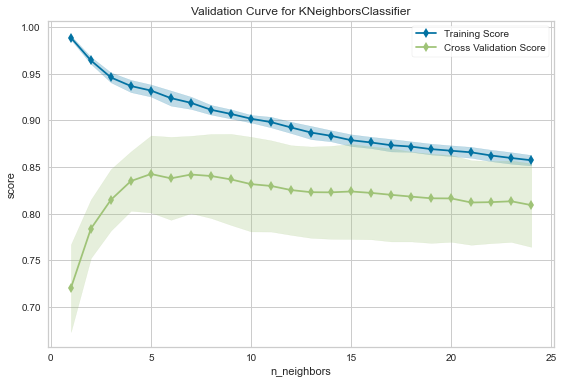

In [219]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(KNeighborsClassifier(), param_name="n_neighbors", param_range=np.arange(1, 25), cv=5, scoring="roc_auc")
viz.fit(X, y)
viz.poof()

# Voting Classifier

In [220]:
log_clf=LogisticRegression(random_state=42)
rnd_clf=RandomForestClassifier(random_state=42)
svm_clf=SVC(probability=True,random_state=42)
knn_clf=KNeighborsClassifier()
dt_clf=DecisionTreeClassifier(random_state=42)

voting_clf=VotingClassifier(estimators=[("lr",log_clf),("rf",forest_clf),("dt",clf),("knn",knn_clf),("xgboost",xgb_clf)],voting="soft")
voting_clf.fit(X_train,y_train)
y_pred_voting=voting_clf.predict(X_test)
print("{} model accuracy score:{}".format(voting_clf,accuracy_score(y_test,y_pred_voting)))
print("{} model ROC score:{}".format (voting_clf,roc_auc_score(y_test,y_pred_voting)))

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [223]:
#Printing results of best performing models together
for clf in (log_clf,cv,clf_tuned,knn_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    y_pred_prob=clf.predict_proba(X_test)[:,1]
    print("{} model ROC score:{}".format (clf,roc_auc_score(y_test,y_pred_prob)))
    print(confusion_matrix(y_test, y_pred))   

Logistic Regression is chosen as my final model taken into account auc score and FP rate

Fitting final model on the whole data set

In [224]:
final_model=log_clf.fit(X,y)

# Using PyCaret for juice classification

In [225]:
data = pd.read_csv("C:/Users/krist/Desktop/Queens/MMA 869/OJ.csv")

In [226]:
from pycaret.classification import *

In [227]:
exp_clf102=setup(data=data,target="Purchase",session_id=42,
                train_size=0.8,
                normalize=True,
                transformation=True,
                ignore_low_variance=True,
                remove_multicollinearity=True,multicollinearity_threshold=0.95,
                profile=True)

In [228]:
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
catboost              CatBoost Classifier   

                                            Reference  Turbo  
ID                                                            
lr            sklearn.linear_model.LogisticRegression   True  
knn            sklearn.neighbors.KNeighborsClassifier   True  
nb                     sklearn.naive_bayes.GaussianNB   True  
dt                sklearn.tree.DecisionTreeClassifier   True  
svm                sklearn.linear_model.SGDClassifier   True  
rbfsvm                                sklearn.svm.SVC  False  
gpc                      sklearn.gaussian_process.GPC  False  
mlp              sklearn.neural_network.MLPClassifier  False  
ridge            sklearn.linear_model.RidgeClassifier   True  
rf            sklearn.ensemble.RandomForestClassifier   True  
qda                 sklearn.discriminant_analysis.QDA   True  
ada               sklearn.ensemble.AdaBoostClassifier   True  
gbc       sklearn.ensemble.GradientBoostingClassifier   True  
lda                 sklearn.discriminant_analysis.LDA   True  
et              sklearn.ensemble.ExtraTreesClassifier   True  
xgboost                        xgboost.readthedocs.io   True  
lightgbm                github.com/microsoft/LightGBM   True  
catboost                                  catboost.ai   True

In [229]:
best_model=compare_models(sort="AUC") 

In [230]:
catboost=create_model("catboost") 

In [231]:
catboost_tuned=tune_model(catboost,optimize="AUC") #slight improvement in performance

In [232]:
catboost_tuned.get_params()

{'iterations': 1000,
 'learning_rate': 0.01,
 'depth': 4,
 'l2_leaf_reg': 10,
 'border_count': 50,
 'silent': True,
 'random_state': 42}

In [233]:
lda=create_model("lda")
lda_tuned=tune_model(lda,optimize="AUC")#slight improvement in performance

In [234]:
lr=create_model("lr")

In [235]:
lr_tuned=tune_model(lr,optimize="AUC") #slight decrease in performance

In [236]:
c_space=np.logspace(-5,8,15)
param_grid={"C":c_space,
           "max_iter":[100,200,300,400],
           "penalty":["l1","l2","elasticnet","none"],
           "solver":["newton-cg","lbfgs","liblinear","sag","saga"]}

lr_tuned_manual=tune_model(lr,custom_grid=param_grid,optimize="AUC") #slight increase in performance

In [237]:
gbc=create_model("gbc")
gbc_tuned=tune_model(gbc,optimize="AUC")

In [238]:
evaluate_model(lr_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

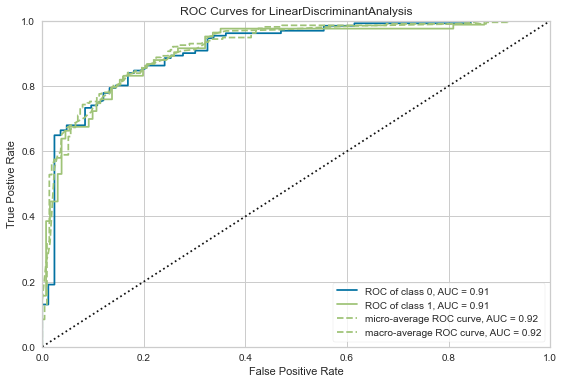

In [239]:
plot_model(lda_tuned,plot="auc")

In [240]:
dt=create_model("dt")

In [241]:
dt_tuned=tune_model(dt)

In [242]:
#Bagging
bagged_dt=ensemble_model(dt_tuned) #AUC impoved by a lot!

In [243]:
boosted_dt=ensemble_model(dt_tuned,method="Boosting")

In [244]:
rf=create_model("rf")
rf_tuned=tune_model(rf)

In [245]:
boosted_rf=ensemble_model(rf_tuned,method="Boosting",n_estimators=300)

In [246]:
stack_soft=stack_models(rf_tuned,dt_tuned)

In [247]:
xgboost=create_model("xgboost")
stack_soft2=stack_models([dt_tuned,rf_tuned,xgboost],meta_model=xgboost)

In [248]:
y_cat=predict_model(catboost_tuned)

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  CatBoost Classifier    0.8458  0.9247   0.747  0.8378  0.7898  0.6687   

      MCC  
0  0.6714

In [249]:
y_lda=predict_model(lda_tuned)

Model  Accuracy     AUC  Recall   Prec.     F1  \
0  Linear Discriminant Analysis    0.8318  0.9104   0.747  0.8052  0.775   

   Kappa     MCC  
0  0.641  0.6421

In [250]:
y_bagged=predict_model(bagged_dt)

Model  Accuracy     AUC  Recall  Prec.      F1   Kappa     MCC
0  Bagging Classifier    0.8318  0.9158  0.7108  0.831  0.7662  0.6361  0.6408

In [252]:
y_rf=predict_model(rf_tuned)

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Random Forest Classifier    0.8505  0.9124  0.7349  0.8592  0.7922  0.6765   

      MCC  
0  0.6816

In [253]:
y_stack=predict_model(stack_soft2)

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Stacking Classifier    0.7897  0.8814  0.7349  0.7262  0.7305  0.5581   

      MCC  
0  0.5582

Catboost is chosen as the best model based on AUC and lowest number of FP

In [254]:
final_pred=finalize_model(catboost_tuned)